Datasets used: 
- `LiptonDataset` :<br>This dataset consists of two features, hair length and
work experience, and supposes a binary classifier that uses these
features to decide whether a given person should be hired.

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt
from sklearn import preprocessing

from IPython.display import Markdown, display

In [2]:
random_seed = 131313
sensitive_attribute = "gender"

## Function to generate synthetic data used by Lipton et al. in arXiv:1711.07076

In [3]:
def generate_lipton(scale=True, num_pts=1000, seed=0):
    '''
    Synthetic data used by Lipton et al. in arXiv:1711.07076
    '''
    np.random.seed(seed)
    work_exp_m = np.random.poisson(31, size=num_pts) - np.random.normal(20, 0.2, size=num_pts)
    work_exp_f = np.random.poisson(25, size=num_pts) - np.random.normal(20, 0.2, size=num_pts)
    
    np.random.seed(seed+1)
    hair_len_m = 35 * np.random.beta(2, 7, size=num_pts)
    hair_len_f = 35 * np.random.beta(2, 2, size=num_pts)
    
    np.random.seed(seed+2)
    ym = np.random.uniform(size=num_pts) < 1 / (1 + np.exp(25.5 - 2.5*work_exp_m))
    yf = np.random.uniform(size=num_pts) < 1 / (1 + np.exp(25.5 - 2.5*work_exp_f))
    
    if scale: #scale the input attributes to zero mean and unit variance
        work_exp = np.concatenate((work_exp_m, work_exp_f))
        work_exp = preprocessing.scale(work_exp)
        work_exp_m = work_exp[:num_pts]
        work_exp_f = work_exp[num_pts:]
        hair_len = np.concatenate((hair_len_m, hair_len_f))
        hair_len = preprocessing.scale(hair_len)
        hair_len_m = hair_len[:num_pts]
        hair_len_f = hair_len[num_pts:]
    
    #combine the input attributes to create the input matrix
    Xm = np.stack((work_exp_m, hair_len_m), axis=1)
    Xf = np.stack((work_exp_f, hair_len_f), axis=1)
    columns = ['work_exp', 'hair_len']
    
    return Xm, Xf, ym, yf, columns

## Load Dataset

In [25]:
Xm, Xf, ym, yf, columns = generate_lipton(num_pts=10000)
Xm = pd.DataFrame(Xm,columns = columns)
Xf = pd.DataFrame(Xm,columns = columns)
Xm['labels'] = ym
Xf['labels'] = yf
Xm['labels'] = np.where((Xm['labels'] == True) , 1, 0)
Xf['labels'] = np.where((Xf['labels'] == True) , 1, 0)
Xm['gender'] = 'Male'
Xf['gender'] = 'Female'
df = pd.concat([Xm,Xf],ignore_index=True, sort=False)
df = df.sample(frac=1).reset_index(drop=True)

# df['work_exp'], cut_bin = pd.qcut(df['work_exp'], q = 3, retbins = True, labels = ['Small','Medium','Big'])
# df['hair_len'], cut_bin = pd.qcut(df['hair_len'], q = 3, retbins = True, labels = ['Short','Medium','Long'])

# df['work_exp'], cut_bin = pd.qcut(df['work_exp'], q = 3, retbins = True, labels = [1, 2, 3])
# df['hair_len'], cut_bin = pd.qcut(df['hair_len'], q = 3, retbins = True, labels = [1, 2, 3])

df['work_exp'], work_exp_cut_bin = pd.qcut(df['work_exp'], q = 3, retbins = True)
df['hair_len'], hair_len_cut_bin = pd.qcut(df['hair_len'], q = 3, retbins = True)

In [26]:
num_features = df._get_numeric_data().columns.to_list()
cate_features = df.select_dtypes(include=['category','object']).columns.to_list()

## Model training and test

In [27]:
X = df.drop('labels', axis=1)
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [28]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

CPU times: total: 31.2 ms
Wall time: 66.5 ms


array([0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.])

In [29]:
X_test

,work_exp,hair_len,gender
0,"(0.836, 3.896]","(-0.427, 1.922]",Female
1,"(0.836, 3.896]","(-0.935, -0.427]",Female
2,"(0.0552, 0.836]","(-0.935, -0.427]",Male
3,"(-2.444, 0.0552]","(-0.427, 1.922]",Female
4,"(0.0552, 0.836]","(-0.935, -0.427]",Male
...,...,...,...
5995,"(-2.444, 0.0552]","(-0.935, -0.427]",Female
5996,"(0.836, 3.896]","(-0.935, -0.427]",Female
5997,"(0.836, 3.896]","(-0.935, -0.427]",Male
5998,"(0.836, 3.896]","(-0.427, 1.922]",Male


In [30]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3901
           1       0.82      0.79      0.80      2099

    accuracy                           0.87      6000
   macro avg       0.86      0.85      0.85      6000
weighted avg       0.86      0.87      0.87      6000



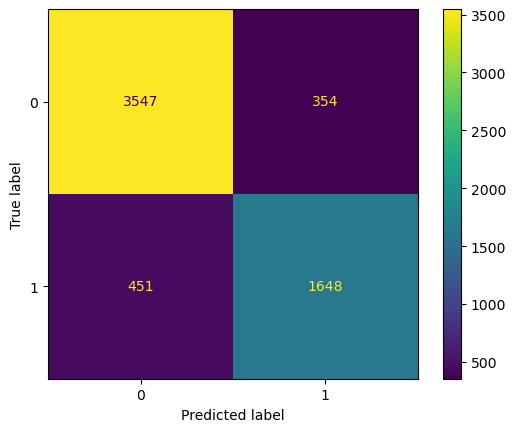

In [31]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# !!!TESTING AREA!!!

In [110]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [35]:
preds = model.predict(X_test)

affected = X_test[preds == 0]
unaffected = X_test[preds == 1]

In [36]:
affected_males = affected[affected.gender == "Male"]
affected_females = affected[affected.gender == "Female"]

In [37]:
affected_males.dtypes

work_exp    object
hair_len    object
gender      object
dtype: object

# !!!TESTING AREA!!!

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [34]:
print_recourse_report(rules_by_if)

If hair_len = (-0.935, -0.427]:
	Subgroup 'Female', 33.91% covered
		Make hair_len = (-1.5659999999999998, -0.935] with correctness 100.00%.
		Make hair_len = (-0.427, 1.922] with correctness 100.00%.
	Subgroup 'Male', 33.13% covered
		Make hair_len = (-1.5659999999999998, -0.935] with correctness 100.00%.
		Make hair_len = (-0.427, 1.922] with correctness 100.00%.
If hair_len = (-1.5659999999999998, -0.935]:
	Subgroup 'Female', 33.15% covered
		Make hair_len = (-0.935, -0.427] with correctness 100.00%.
		Make hair_len = (-0.427, 1.922] with correctness 100.00%.
	Subgroup 'Male', 32.62% covered
		Make hair_len = (-0.935, -0.427] with correctness 100.00%.
		Make hair_len = (-0.427, 1.922] with correctness 100.00%.
If hair_len = (-0.427, 1.922]:
	Subgroup 'Female', 32.95% covered
		Make hair_len = (-0.935, -0.427] with correctness 100.00%.
		Make hair_len = (-1.5659999999999998, -0.935] with correctness 100.00%.
	Subgroup 'Male', 34.25% covered
		Make hair_len = (-0.935, -0.427] with cor

In [32]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [33]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
     X_test,
     model=model,
     sensitive_attribute='gender',
     missing_subgroup_val="Unknown"
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.84it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]

Computing correctenesses for all valid if-thens.



100%|█████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 309.96it/s]

Number of if-thens: 26


In [24]:
# #### Uncomment if you wish to load rules object from disk

# import dill

# with open("rulesLipton.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [25]:
# #### Uncomment if you wish to save rules object on disk

# import dill

# with open("rulesLipton.data", "wb") as outf:
#      dill.dump(rules_by_if, outf)

In [14]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If hair_len = 2:
	Subgroup 'Female', 33.91% covered
		Make hair_len = 1 with correctness 100.00%.
		Make hair_len = 3 with correctness 100.00%.
	Subgroup 'Male', 33.13% covered
		Make hair_len = 1 with correctness 100.00%.
		Make hair_len = 3 with correctness 100.00%.
If hair_len = 1:
	Subgroup 'Female', 33.15% covered
		Make hair_len = 2 with correctness 100.00%.
		Make hair_len = 3 with correctness 100.00%.
	Subgroup 'Male', 32.62% covered
		Make hair_len = 2 with correctness 100.00%.
		Make hair_len = 3 with correctness 100.00%.
If hair_len = 3:
	Subgroup 'Female', 32.95% covered
		Make hair_len = 2 with correctness 100.00%.
		Make hair_len = 1 with correctness 100.00%.
	Subgroup 'Male', 34.25% covered
		Make hair_len = 2 with correctness 100.00%.
		Make hair_len = 1 with correctness 100.00%.
If work_exp = 1:
	Subgroup 'Female', 32.75% covered
		Make work_exp = 2 with correctness 100.00%.
		Make work_exp = 3 with correctness 100.00%.
	Subgroup 'Male', 100.00% covered
		Make work_exp

In [48]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If hair_len = 2:
	Subgroup 'Female', 33.91% covered
		Make hair_len = 1 with correctness 100.00%.
		Make hair_len = 3 with correctness 100.00%.
	Subgroup 'Male', 33.13% covered
		Make hair_len = 1 with correctness 100.00%.
		Make hair_len = 3 with correctness 100.00%.
If hair_len = 1:
	Subgroup 'Female', 33.15% covered
		Make hair_len = 2 with correctness 100.00%.
		Make hair_len = 3 with correctness 100.00%.
	Subgroup 'Male', 32.62% covered
		Make hair_len = 2 with correctness 100.00%.
		Make hair_len = 3 with correctness 100.00%.
If hair_len = 3:
	Subgroup 'Female', 32.95% covered
		Make hair_len = 2 with correctness 100.00%.
		Make hair_len = 1 with correctness 100.00%.
	Subgroup 'Male', 34.25% covered
		Make hair_len = 2 with correctness 100.00%.
		Make hair_len = 1 with correctness 100.00%.
If work_exp = 1:
	Subgroup 'Female', 32.75% covered
		Make work_exp = 2 with correctness 100.00%.
		Make work_exp = 3 with correctness 100.00%.
	Subgroup 'Male', 100.00% covered
		Make work_exp

In [31]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If hair_len = (-0.935, -0.427]:
	Subgroup 'Female', 33.91% covered
		Make hair_len = (-1.5659999999999998, -0.935] with correctness 100.00%.
		Make hair_len = (-0.427, 1.922] with correctness 100.00%.
	Subgroup 'Male', 33.13% covered
		Make hair_len = (-1.5659999999999998, -0.935] with correctness 100.00%.
		Make hair_len = (-0.427, 1.922] with correctness 100.00%.
If hair_len = (-1.5659999999999998, -0.935]:
	Subgroup 'Female', 33.15% covered
		Make hair_len = (-0.935, -0.427] with correctness 100.00%.
		Make hair_len = (-0.427, 1.922] with correctness 100.00%.
	Subgroup 'Male', 32.62% covered
		Make hair_len = (-0.935, -0.427] with correctness 100.00%.
		Make hair_len = (-0.427, 1.922] with correctness 100.00%.
If hair_len = (-0.427, 1.922]:
	Subgroup 'Female', 32.95% covered
		Make hair_len = (-0.935, -0.427] with correctness 100.00%.
		Make hair_len = (-1.5659999999999998, -0.935] with correctness 100.00%.
	Subgroup 'Male', 34.25% covered
		Make hair_len = (-0.935, -0.427] with cor

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [81]:
feature_weights = {"hair_len": 1, "work_exp": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [82]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If work_exp = Small, hair_len = Small:
	Subgroup 'Female', 11.62% covered out of 10000
		Make work_exp = Big, hair_len = Medium with correctness 0.00%.
		Make work_exp = Big, hair_len = Big with correctness 0.00%.
		Make work_exp = Big with correctness 0.00%.
		Aggregate cost of the above recourses = -0e+00
	Subgroup 'Male', 32.62% covered out of 10000
		Make work_exp = Big, hair_len = Medium with correctness 100.00%.
		Make work_exp = Big, hair_len = Big with correctness 100.00%.
		Make work_exp = Big with correctness 100.00%.
		Aggregate cost of the above recourses = -2e+00
	Bias against Female. Unfairness measure = 1.67.
If work_exp = Small, hair_len = Medium:
	Subgroup 'Female', 10.86% covered out of 10000
		Make work_exp = Big with correctness 0.00%.
		Make work_exp = Big, hair_len = Big with correctness 0.00%.
		Make work_exp = Big, hair_len = Small with correctness 0.00%.
		Aggregate cost of the above recourses = -0e+00
	Subgroup 'Male', 33.13% covered out of 10000
		Make work_e

## Minimum cost above threshold

In [83]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If work_exp = Small:
	Subgroup 'Female', 32.75% covered out of 10000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 100.00% covered out of 10000
		Make work_exp = Medium with correctness 100.00%.
		Make work_exp = Big with correctness 100.00%.
		Aggregate cost of the above recourses = 1e+00
	Bias against Female. Unfairness measure = inf.
If work_exp = Small, hair_len = Small:
	Subgroup 'Female', 11.62% covered out of 10000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 32.62% covered out of 10000
		Make work_exp = Big, hair_len = Medium with correctness 100.00%.
		Make work_exp = Big, hair_len = Big with correctness 100.00%.
		Make work_exp = Big with correctness 100.00%.
		Aggregate cost of the above recourses = 1e+00
	Bias against Female. Unfairness measure = inf.
If work_exp = Small, hair_len = Medium:
	Subgroup 'Female', 10.86% covered out of 10000
		No recourses for this subgroup!

## Mean cost above threshold

In [84]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If work_exp = Small:
	Subgroup 'Female', 32.75% covered out of 10000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 100.00% covered out of 10000
		Make work_exp = Medium with correctness 100.00%.
		Make work_exp = Big with correctness 100.00%.
		Aggregate cost of the above recourses = 1e+00
	Bias against Female. Unfairness measure = inf.
If work_exp = Small, hair_len = Small:
	Subgroup 'Female', 11.62% covered out of 10000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 32.62% covered out of 10000
		Make work_exp = Big, hair_len = Medium with correctness 100.00%.
		Make work_exp = Big, hair_len = Big with correctness 100.00%.
		Make work_exp = Big with correctness 100.00%.
		Aggregate cost of the above recourses = 2e+00
	Bias against Female. Unfairness measure = inf.
If work_exp = Small, hair_len = Medium:
	Subgroup 'Female', 10.86% covered out of 10000
		No recourses for this subgroup!

## Number above threshold

In [85]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If work_exp = Small, hair_len = Small:
	Subgroup 'Female', 11.62% covered out of 10000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0e+00
	Subgroup 'Male', 32.62% covered out of 10000
		Make work_exp = Big, hair_len = Medium with correctness 100.00%.
		Make work_exp = Big, hair_len = Big with correctness 100.00%.
		Make work_exp = Big with correctness 100.00%.
		Aggregate cost of the above recourses = -3e+00
	Bias against Female. Unfairness measure = 3.
If work_exp = Small, hair_len = Medium:
	Subgroup 'Female', 10.86% covered out of 10000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0e+00
	Subgroup 'Male', 33.13% covered out of 10000
		Make work_exp = Big with correctness 100.00%.
		Make work_exp = Big, hair_len = Big with correctness 100.00%.
		Make work_exp = Big, hair_len = Small with correctness 100.00%.
		Aggregate cost of the above recourses = -3e+00
	Bias against Female. Unfairness measure = 3.
If work_exp = Small, h

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [22]:
len(rules_by_if)

6

In [23]:
import dill

with open("stateLipton.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

If hair_len = Short, work_exp = Small:
	Subgroup 'Female', 10.60% covered out of 82
		Make hair_len = Long, work_exp = Big with correctness 0.00%.
		Make hair_len = Medium, work_exp = Medium with correctness 0.00%.
		Make work_exp = Big with correctness 0.00%.
		Make hair_len = Medium, work_exp = Big with correctness 0.00%.
		Make work_exp = Medium with correctness 0.00%.
	Subgroup 'Male', 30.00% covered out of 118
		Make hair_len = Long, work_exp = Big with correctness 100.00%.
		Make hair_len = Medium, work_exp = Medium with correctness 100.00%.
		Make work_exp = Big with correctness 100.00%.
		Make hair_len = Medium, work_exp = Big with correctness 100.00%.
		Make work_exp = Medium with correctness 100.00%.
	Bias against Female. Unfairness measure = 1.6.
	Cumulative correctness plot for the above recourses:


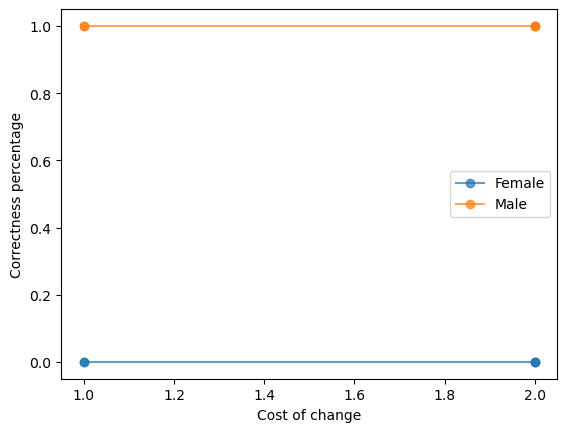

If hair_len = Medium, work_exp = Small:
	Subgroup 'Female', 8.61% covered out of 82
		Make hair_len = Long, work_exp = Big with correctness 0.00%.
		Make work_exp = Medium with correctness 0.00%.
		Make hair_len = Short, work_exp = Big with correctness 0.00%.
		Make work_exp = Big with correctness 0.00%.
		Make hair_len = Short, work_exp = Medium with correctness 0.00%.
	Subgroup 'Male', 36.00% covered out of 118
		Make hair_len = Long, work_exp = Big with correctness 100.00%.
		Make work_exp = Medium with correctness 100.00%.
		Make hair_len = Short, work_exp = Big with correctness 100.00%.
		Make work_exp = Big with correctness 100.00%.
		Make hair_len = Short, work_exp = Medium with correctness 100.00%.
	Bias against Female. Unfairness measure = 1.6.
	Cumulative correctness plot for the above recourses:


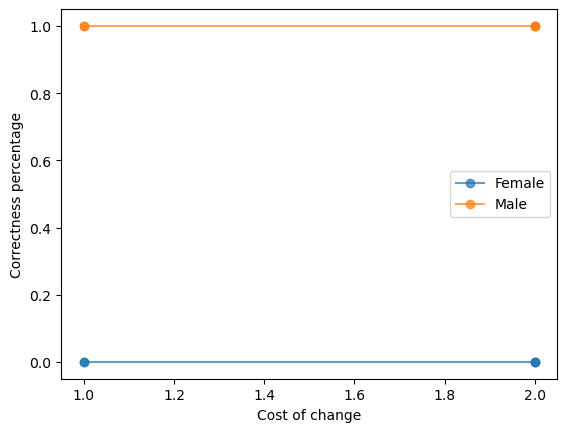

If work_exp = Small:
	Subgroup 'Female', 31.13% covered out of 82
		Make work_exp = Big with correctness 0.00%.
		Make work_exp = Medium with correctness 0.00%.
	Subgroup 'Male', 100.00% covered out of 118
		Make work_exp = Big with correctness 100.00%.
		Make work_exp = Medium with correctness 100.00%.
	Bias against Female. Unfairness measure = 1.0.
	Cumulative correctness plot for the above recourses:


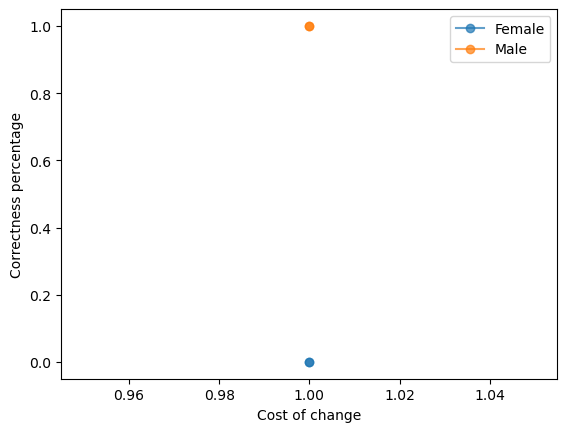

If work_exp = Small, hair_len = Long:
	Subgroup 'Female', 11.92% covered out of 82
		Make work_exp = Medium with correctness 0.00%.
	Subgroup 'Male', 34.00% covered out of 118
		Make work_exp = Medium with correctness 100.00%.
	Bias against Female. Unfairness measure = 1.0.
	Cumulative correctness plot for the above recourses:


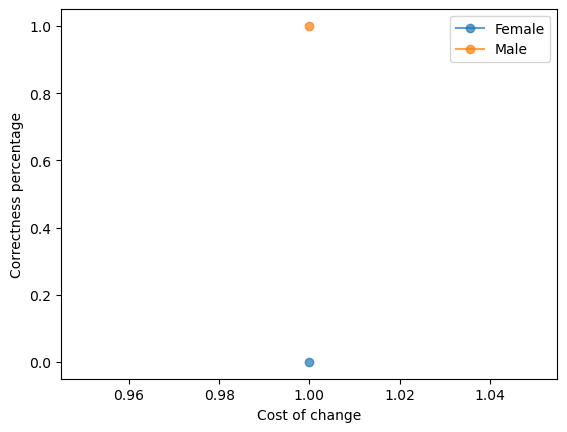

If hair_len = Long:
	Subgroup 'Female', 36.42% covered out of 82
		Make hair_len = Medium with correctness -0.00%.
		Make hair_len = Short with correctness -0.00%.
	Subgroup 'Male', 34.00% covered out of 118
		Make hair_len = Medium with correctness 0.00%.
		Make hair_len = Short with correctness 0.00%.
	Bias against Female. Unfairness measure = 0.0.
	Cumulative correctness plot for the above recourses:


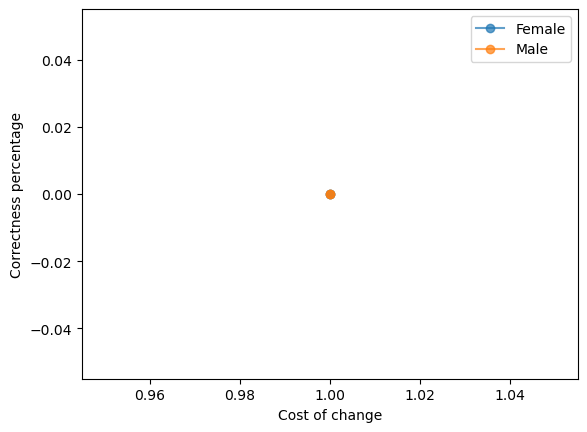

If hair_len = Short:
	Subgroup 'Female', 32.12% covered out of 82
		Make hair_len = Medium with correctness -0.00%.
		Make hair_len = Long with correctness -0.00%.
	Subgroup 'Male', 30.00% covered out of 118
		Make hair_len = Medium with correctness 0.00%.
		Make hair_len = Long with correctness 0.00%.
	Bias against Female. Unfairness measure = 0.0.
	Cumulative correctness plot for the above recourses:


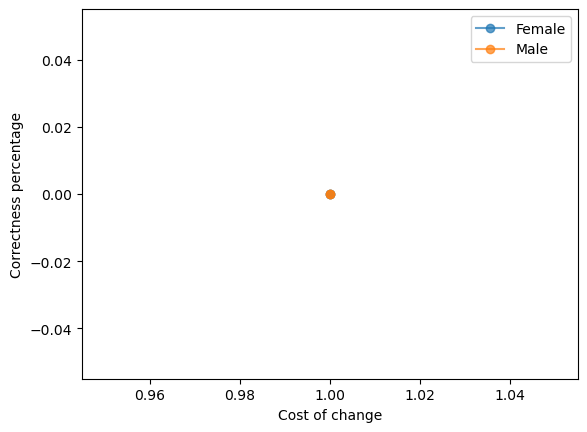

If hair_len = Medium:
	Subgroup 'Female', 31.46% covered out of 82
		Make hair_len = Short with correctness 0.00%.
		Make hair_len = Long with correctness 0.00%.
	Subgroup 'Male', 36.00% covered out of 118
		Make hair_len = Short with correctness 0.00%.
		Make hair_len = Long with correctness 0.00%.
	No bias!
	Cumulative correctness plot for the above recourses:


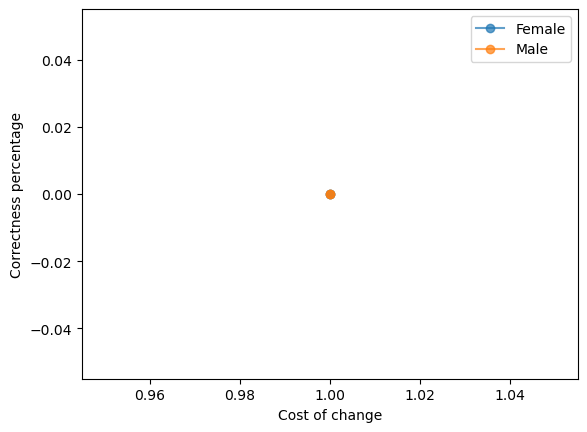

In [24]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="weighted-average",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (X[sensitive_attribute] == sg).sum() for sg in X[sensitive_attribute].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [25]:
import dill

with open("stateLipton.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)